# AirBnB : Features selection ALL CITIES

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.feature_selection import chi2,f_classif
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.grid_search import GridSearchCV

from xgboost import XGBClassifier

from utils import rstr,distance

import pickle

airBColor= '#ff5a5f'
airBColor2= '#008489'

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('../../data/all_cities/listing_cleansed_fillna.csv')

print df.host_id.isnull().sum()
df.drop('listings_per_host',axis=1,inplace=True)
#df = df[df.city.isin(['antwerp','geneva','berlin','paris','london','amsterdam'])]

0


### Add distance to city center

In [3]:
df_city_center = pd.read_csv('../../data/all_cities/distance_to_center.csv')

In [4]:
city_center_dict =df_city_center.to_dict(orient='index')
df['coordinate']=list(zip(df.latitude, df.longitude))

In [5]:
coord_brandenburg_tor = (52.516849,13.377661)

def distance_highlight(center_coord,x):
    return distance(center_coord,x)

for city in city_center_dict.values():
    center_coord = (city['latitude'],city['longitude'])
    city_center_name = ''.join(['distance_to_center_',city['city']])
    df[city_center_name] = df['coordinate'].apply(lambda x : distance_highlight(center_coord,x))
    
df.drop('coordinate',axis=1,inplace=True) 

### Filter on numeric features

In [6]:
cols_num = df.select_dtypes(['number']).columns.tolist()
cols_not_num = set(df.columns.tolist())-set(cols_num)
cols_not_num

{'city'}

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_sample = df.select_dtypes(include=numerics)

### Remove listing with no reviews

In [8]:
df = df[df_sample.availability_90>0]

In [9]:
df.shape

(56879, 411)

### Replace abnormal values and missing data

In [10]:
df.maximum_nights.sort_values().tail(300)

22512          1125
23103          1125
22513          1125
22514          1125
23099          1125
22523          1125
22543          1125
22515          1125
22516          1125
22522          1125
23104          1125
22521          1125
23100          1125
22525          1125
22532          1125
22504          1125
22533          1125
23113          1125
23112          1125
22541          1125
22540          1125
23093          1125
23094          1125
22484          1125
22485          1125
23095          1125
23096          1125
22503          1125
22487          1125
23108          1125
            ...    
3057         100000
25406        100000
14926        100000
4182         100100
3828         299999
22052        555555
27759       1000000
4928        9999999
3336        9999999
40308      10000000
4018       21001000
5336       99999999
2747       99999999
3349      999999999
3886      999999999
14976     999999999
33172    1000000000
40571    2147483647
49837    2147483647


In [11]:
df.loc[df['maximum_nights'] > 1125, 'maximum_nights'] = 1125


In [12]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


### Add target label

In [13]:
TARGET = 'multihost'

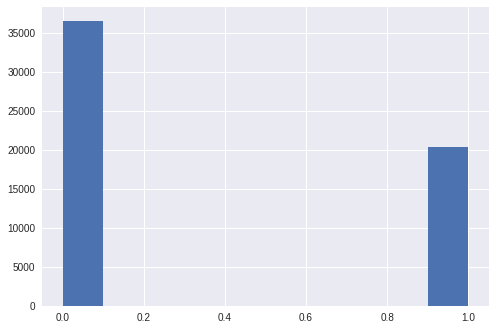

In [14]:
df.multihost.hist()

### Split Features and Target 

In [15]:
print df.shape
df_sample  = df_sample.sample(frac=.2).copy()
print df_sample.shape
print df.shape

(56879, 411)
(11376, 410)
(56879, 411)


In [16]:
y = df_sample[TARGET]
X = df_sample.drop([TARGET,'listing_id','host_id'],axis=1)

### Drop zero variance and Scale X 

In [17]:
print X.shape
X = X.loc[:, X.std()>0]
print X.shape

(11376, 407)
(11376, 388)


In [18]:
X = X.apply(lambda x: MinMaxScaler().fit_transform(x),axis=0)

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/ramon/anaconda2/l

In [19]:
print X.shape,y.shape

(11376, 388) (11376,)


### Correlation matrix

### Selection using RandomizedLogisticRegression_selector

In [20]:
def RandomizedLogisticRegression_selector(X,y):
    clf = RandomizedLogisticRegression()
    columns = X.columns
    clf.fit(X,y)
    idx =  clf.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [21]:
features_RLR = RandomizedLogisticRegression_selector(X,y)

In [22]:
features_RLR
pickle.dump(features_RLR, open('best_features/features_RLR.p', 'wb'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dd0682dd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9dceaf27d0>]], dtype=object)

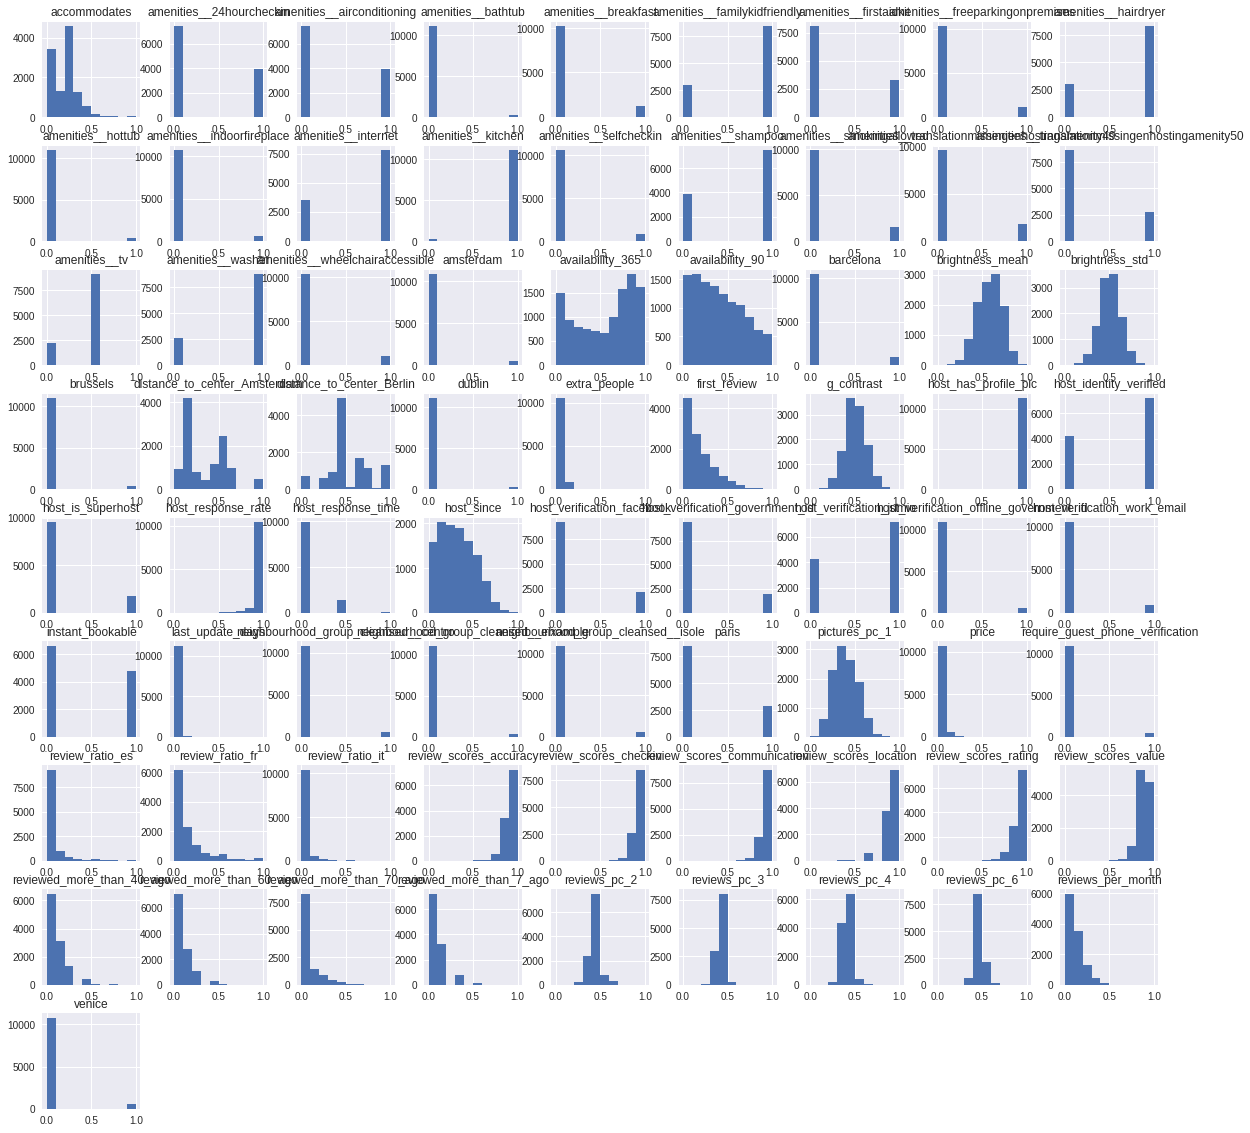

In [23]:
X[features_RLR].hist(figsize=(20,20))

In [24]:
not_binary_values = [col for col in X[features_RLR] if 
               not X[col].dropna().value_counts().index.isin([0,1]).all()]
not_binary_values 

['accommodates',
 'amenities__tv',
 'availability_365',
 'availability_90',
 'extra_people',
 'first_review',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'last_update_days',
 'price',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'reviewed_more_than_7_ago',
 'reviewed_more_than_40_ago',
 'reviewed_more_than_60_ago',
 'reviewed_more_than_70_ago',
 'review_ratio_es',
 'review_ratio_fr',
 'review_ratio_it',
 'reviews_pc_2',
 'reviews_pc_3',
 'reviews_pc_4',
 'reviews_pc_6',
 'pictures_pc_1',
 'g_contrast',
 'brightness_mean',
 'brightness_std',
 'distance_to_center_Amsterdam',
 'distance_to_center_Berlin']

In [25]:
features_to_log =['accommodates',
  'availability_365',
  'first_review',
  'host_since',
  'latitude',
  'price',
  'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_rating',
 'review_scores_value',
  'reviews_per_month',
 'reviewed_more_than_40_ago',
 'reviewed_more_than_60_ago',
 'reviewed_more_than_70_ago',
  'host_response_rate',
 'amenities__tv',
 'host_response_time',
 'last_update_days',
]

### Selection using KbestSelection

In [26]:
def SelectKBest_features(X,y,method, n_features):
    selector = SelectKBest(method, k=n_features)
    selector.fit(X, y)
    # Get idxs of columns to keep
    idx =  selector.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [27]:
features_Kbest_chi2 = SelectKBest_features(X,y,chi2,100)
features_Kbest_fclass = SelectKBest_features(X,y,f_classif,100)

In [28]:
features_Kbest_chi2
pickle.dump(features_Kbest_chi2, open('best_features/features_Kbest_chi2.p', 'wb'))
pickle.dump(features_Kbest_fclass, open('best_features/features_Kbest_fclass.p', 'wb'))

In [29]:
features_Kbest_fclass

['accommodates',
 'amenities__24hourcheckin',
 'amenities__airconditioning',
 'amenities__breakfast',
 'amenities__doormanentry',
 'amenities__familykidfriendly',
 'amenities__fireextinguisher',
 'amenities__freeparkingonpremises',
 'amenities__hairdryer',
 'amenities__hangers',
 'amenities__iron',
 'amenities__lockbox',
 'amenities__selfcheckin',
 'amenities__smokedetector',
 'amenities__smokingallowed',
 'amenities__suitableforevents',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenity50',
 'amenities__tv',
 'availability_365',
 'availability_90',
 'bathrooms',
 'bed_type_pulloutsofa',
 'bed_type_realbed',
 'bedrooms',
 'beds',
 'first_review',
 'guests_included',
 'host_identity_verified',
 'host_is_superhost',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_verification_facebook',
 'host_verification_government_id',
 'host_verification_jumio',
 'host_verification_manual_offline',
 'host_verification_offline_govern

### Selection using Xgboost

In [30]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

In [31]:
params = {
    'max_depth':12,
    'min_child_weight':2,
    'learning_rate' :0.1,
    'gamma':0.0,
    'n_estimators':200
}

print params

clf = XGBClassifier(**params)


best_clf = clf.fit(X,y)
print(best_clf)

{'n_estimators': 200, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 2}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


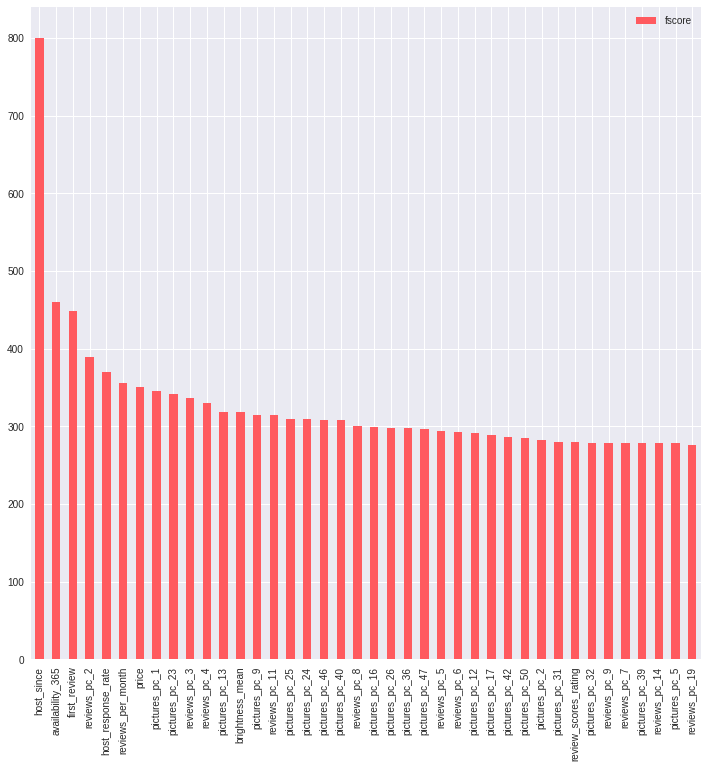

In [32]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

In [33]:
XGB_features = features_weights.sort_values(by='fscore',ascending=False).head(100).index.tolist()
pickle.dump(XGB_features,open('XGB_features.p','wb'))

### Plot best  5 features from Kbest fclass

In [34]:
df_scatter_plot = X[XGB_features[:5]]
df_scatter_plot['is_multihost']=y

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
df_scatter_plot.columns = [f.replace("amenities__translationmissingenhosting","") for f in df_scatter_plot.columns]

In [36]:
df_scatter_plot.columns

Index([u'host_since', u'availability_365', u'first_review', u'reviews_pc_2',
       u'host_response_rate', u'is_multihost'],
      dtype='object')

In [37]:
good_features = df_scatter_plot.columns.tolist()

good_features.remove('is_multihost')

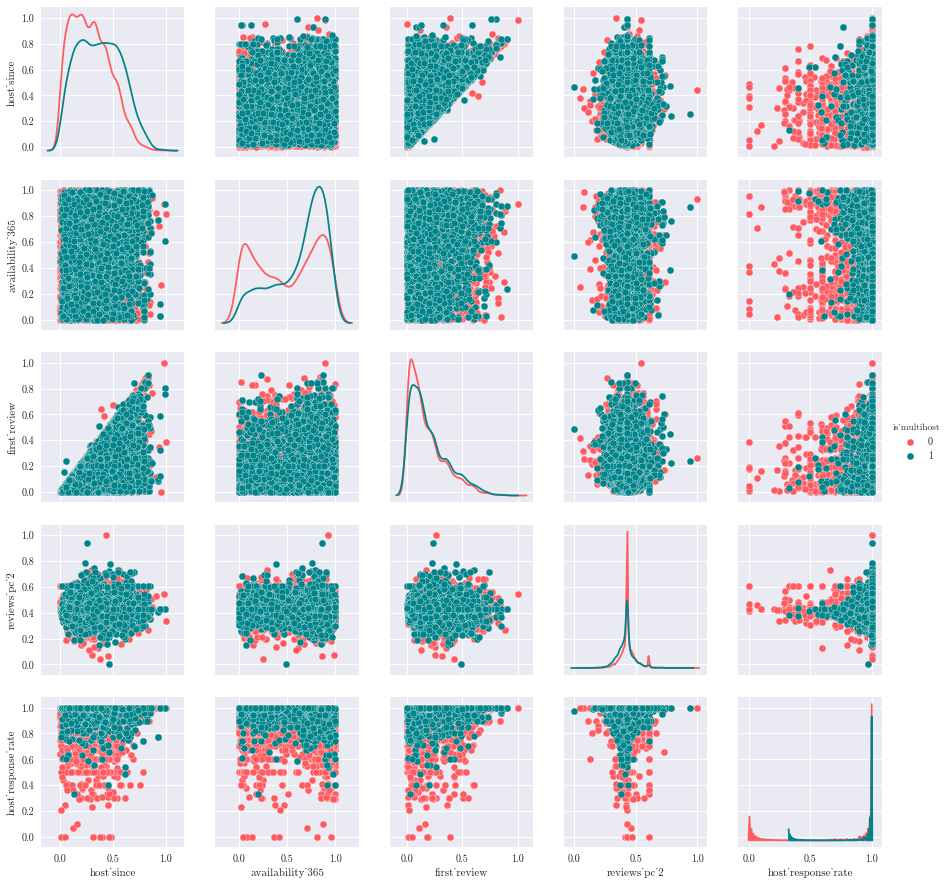

In [38]:
sns.set_style("darkgrid", { 'font.family': ['cmr10']})
sns.pairplot(df_scatter_plot, hue="is_multihost",diag_kind='kde',vars=good_features,palette={0:airBColor,1:airBColor2})


### Create a list of the overall best features

In [39]:
BEST_FEATURES = list(set(features_RLR+XGB_features+features_Kbest_chi2+features_Kbest_fclass+['latitude','longitude']))
len(BEST_FEATURES)

208

In [40]:
BEST_FEATURES.sort()
pickle.dump(BEST_FEATURES,open('best_features/best_features.p','wb'))

In [41]:
df_dataset_for_modeling = pd.concat([df[TARGET],df[BEST_FEATURES],df['city']],axis=1)
df_dataset_for_modeling[features_to_log]= np.log(df_dataset_for_modeling[features_to_log]+1)

In [42]:
df_dataset_for_modeling.to_csv('../../data/all_cities/dataset_for_modeling.csv',index=None)

In [43]:
df_dataset_for_modeling.head()

,multihost,accommodates,amenities__24hourcheckin,amenities__airconditioning,amenities__bathtub,amenities__breakfast,amenities__carbonmonoxidedetector,amenities__cats,amenities__crib,amenities__doorman,...,reviews_pc_4,reviews_pc_5,reviews_pc_6,reviews_pc_7,reviews_pc_8,reviews_pc_9,reviews_per_month,roma,venice,city
0,0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024888,-0.055772,0.094112,0.045136,-0.072911,-0.096355,1.223775,0,0,amsterdam
1,0,1.386294,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.086997,-0.060118,-0.410276,-0.146006,-0.011183,0.100233,0.896088,0,0,amsterdam
2,0,1.386294,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.075284,0.116812,0.145338,0.037120,-0.136319,-0.170814,0.693147,0,0,amsterdam
3,0,1.609438,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-0.001532,-0.030504,-0.057160,-0.108607,-0.028863,0.043528,1.098612,0,0,amsterdam
4,0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.189467,-0.135179,-0.321734,0.061121,-0.113399,-0.119609,0.587787,0,0,amsterdam
